# Intent Classification of Airline Travel Website Questions
By Suet Ying Lee, Juliet Gaithuru and Jennifer Isoa

In [30]:
#!pip install tensorflow --ignore-installed

In [6]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Training, testing
from sklearn.model_selection import train_test_split

#For NLP
import tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional,Embedding

## Loading data

In [7]:
# Read data using pandas

df=pd.read_csv('atis_intents.csv')
df.columns = ["question_category", "question"]
df.head()

,question_category,question
0,atis_flight,what flights are available from pittsburgh to...
1,atis_flight_time,what is the arrival time in san francisco for...
2,atis_airfare,cheapest airfare from tacoma to orlando
3,atis_airfare,round trip fares from pittsburgh to philadelp...
4,atis_flight,i need a flight tomorrow from columbus to min...


## Exploratory Data Analysis

In [8]:
df.shape

(4977, 2)

In [9]:
# To explore the datatype of each column

df.dtypes
#df.info()

question_category    object
question             object
dtype: object

We can see that most of our data types are in a suitable format for machine learning except for columns having object type, and we'd need to carry out some preprocessing on them using sklearn or drop them if we consider them unimportant for our analysis.

In [10]:
df.describe()

,question_category,question
count,4977,4977
unique,22,4633
top,atis_flight,what is fare code h
freq,3665,8


In [11]:
# Drop duplicates if it exists

#df.drop_duplicates(inplace=True)

In [12]:
df.shape  # there are no duplicate rows since our data dimension did not reduce 

(4977, 2)

### Defining the text and the labels

In [13]:
text = df["question_category"]
labels = df["question"]

In [14]:
text.head()
labels.head()

0     what flights are available from pittsburgh to...
1     what is the arrival time in san francisco for...
2              cheapest airfare from tacoma to orlando
3     round trip fares from pittsburgh to philadelp...
4     i need a flight tomorrow from columbus to min...
Name: question, dtype: object

### Splitting into training and test data

In [15]:
train_text,test_text,train_labels,test_labels = train_test_split(text,labels,test_size = 0.3)

### Preprocessing the data by tokenizing the dataset

Breaking down sentences into numerical representations

In [16]:
max_num_words = 40000
classes = np.unique(labels)

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

#### Padding all training phrases with 0 so that all phrases are the same length. This makes it digestible by the deep learning model.

In [17]:
lst=[]
for c in train_text:
    lst.append(len(c.split()))
maxLen=int(np.percentile(lst, 98))
train_sequences = tokenizer.texts_to_sequences(train_text)
train_sequences = pad_sequences(train_sequences, maxlen=maxLen, padding='post')
test_sequences = tokenizer.texts_to_sequences(test_text)
test_sequences = pad_sequences(test_sequences, maxlen=maxLen, padding='post')

In [18]:
lst[:5]

[1, 1, 1, 1, 1]

#### Converting the labels into one-hot encoding

In [19]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder.fit(integer_encoded)
train_label_encoded = label_encoder.transform(train_labels)
train_label_encoded = train_label_encoded.reshape(len(train_label_encoded), 1)
train_labels = onehot_encoder.transform(train_label_encoded)

test_labels_encoded = label_encoder.transform(test_labels)
test_labels_encoded = test_labels_encoded.reshape(len(test_labels_encoded), 1)
test_labels = onehot_encoder.transform(test_labels_encoded)

In [20]:
#training: train_sequences, train_labels
#testing: test_sequences, test_labels

Text(0, 0.5, 'Frequency')

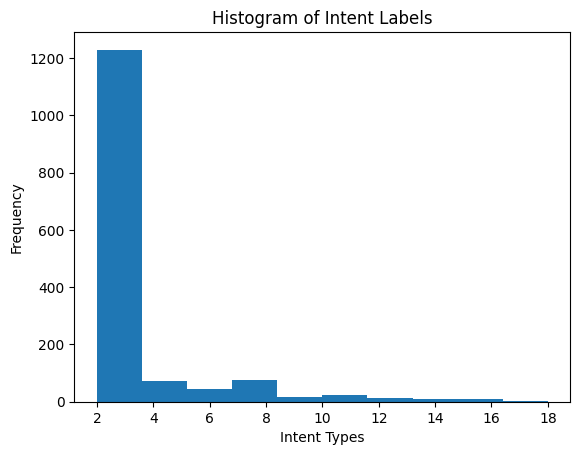

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(test_sequences)

# Add labels
plt.title('Histogram of Intent Labels')
plt.xlabel('Intent Types')
plt.ylabel('Frequency')

### Using GloVe to enhance learning.

GloVe (Global Vectors for Word Representation) is an unsupervised learning algorithm for obtaining vector representations for words. 
Training is performed on aggregated global word-word co-occurrence statistics from a corpus.

In [22]:
#!pip install wget

In [ ]:
import wget

url ='https://www.dropbox.com/s/a247ju2qsczh0be/glove.6B.100d.txt?dl=1'
wget.download(url)

In [23]:
#storing wget in a Python dictionary
embeddings_index={}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

#### GloVe contains vector representation of all the words from a large corpus. We only need those word vectors present in our corpus.
We will create an embedding matrix containing vector representations of words present in our dataset only.

In [24]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
num_words = min(max_num_words, len(word_index))+1
embedding_dim=len(embeddings_index['the'])
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_num_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

C:\Users\jngai\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


### Model Training and Validation

#### Creating a model with an embedding layer made up of weighted encoding.

In [25]:
model = Sequential()

model.add(Embedding(num_words, 100, trainable=False,input_length=train_sequences.shape[1], weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
model.add(Dropout(0.3))
model.add(Dense(50, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(classes.shape[0], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [26]:
trained_model = model.fit(train_sequences, train_labels, epochs = 20, batch_size = 128, shuffle=True, validation_data=[test_sequences, test_labels])

Epoch 1/20
28/28 [==============================] - 6s 57ms/step - loss: 8.4446 - acc: 0.0000e+00 - val_loss: 8.4401 - val_acc: 0.0000e+00
Epoch 2/20
28/28 [==============================] - 1s 40ms/step - loss: 8.4311 - acc: 8.6133e-04 - val_loss: 8.6254 - val_acc: 6.6934e-04
Epoch 3/20
28/28 [==============================] - 1s 36ms/step - loss: 8.3232 - acc: 0.0014 - val_loss: 9.5141 - val_acc: 6.6934e-04
Epoch 4/20
28/28 [==============================] - 1s 36ms/step - loss: 8.1573 - acc: 0.0011 - val_loss: 9.9992 - val_acc: 0.0013
Epoch 5/20
28/28 [==============================] - 1s 35ms/step - loss: 8.0261 - acc: 0.0029 - val_loss: 10.0599 - val_acc: 0.0013
Epoch 6/20
28/28 [==============================] - 1s 37ms/step - loss: 7.9205 - acc: 0.0052 - val_loss: 10.4048 - val_acc: 0.0020
Epoch 7/20
28/28 [==============================] - 1s 36ms/step - loss: 7.8422 - acc: 0.0049 - val_loss: 10.3419 - val_acc: 0.0020
Epoch 8/20
28/28 [==============================] - 1s 36ms/

### Visualizing the accuracy of the trained model

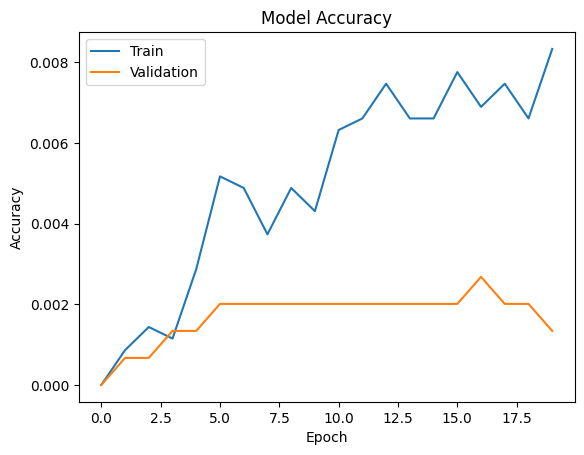

In [27]:
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Visualizing the loss of the trained model

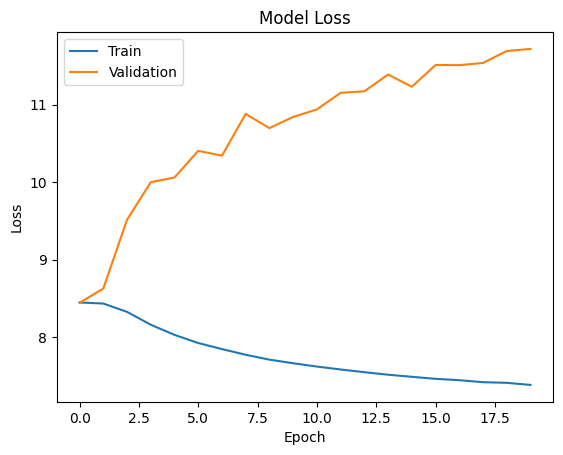

In [28]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Conclusion:

This dataset is imbalanced because some question categories have very few samples, which results in the low intent classification accuracy.

#### References

1. https://nlp.stanford.edu/projects/glove/
2. https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6
3. https://github.com/stanfordnlp/GloVe
4. Dataset: https://www.kaggle.com/code/hassanamin/atis-intent-classification-using-svm-and-spacy/notebook